Modelo para a predição de sobrevidade de pacientes de câncer de pulmão de células não pequenas
===================

### Autores: Glauber Nascimento, Maria Emily Gomes, Rafael Anis

## Introdução

<p style="text-align:justify;"> Nesse notebook, utilizou-se o banco de dados <i>MSK MetTropism</i>, o qual foi produzido e estudado pelo grupo o qual publicou "Genomic characterization of metastatic patterns from prospective clinical sequencing of 25,000 patients". No artigo, com a análise do genôma e das informações clínicas dos pacientes, foi identificado uma associação entre alterações genômicas e padrões de disseminação. Nosso projeto, no entanto, irá utilizar essa vasta informação e tentar predizer o tempo de sobrevida de pacientes de <strong>Câncer de pulmão de células não pequenas</strong>. Desse modo, queremos identificar pacientes os quais precisam de maior atenção médica e os que possivelmente estarão curados, ou seja, irão obter uma expectativa de sobrevida maior que cinco anos. Portanto, o projeto se propôs a utilizar ferramentas de aprendizado de máquina para separar pacientes curados dos não curados e, para os não curados, os que obtiveram expectativa de sobrevida menor que cinco anos, mostrar o tempo predito para, então, conseguir mensurar a gravidade do estado de cada paciente e a possível necessidade de tratamentos mais intensos.
<p style="text-align:justify;"> Para conseguir os melhores resultados, não só especificamos um tipo de câncer para treinar o modelo, como dividimos as observações do dataset em dados de treino e de teste para verificar a performance e foram feitas otimizações de hiperparâmetros por Optuna. Para o processo de predição foram feitos dois modelos, um <strong>classificador</strong> e um de <strong>regressão</strong>.

<p style="text-align:justify;">  O <strong>classificador</strong> teria como objetivo discernir pacientes curados dos que tem expectativa de sobrevida menor do que 5 anos. Buscando o melhor classificador, foram comparados os algoritmos de classificador baseline, regressão logística e floresta aleatória. A métrica de perfomance utiliza foi a área abaixo de uma curva Precisão-Sensibilidade (Precision-Recall Curve), considerando que os dados são extremamente balanceados, havendo muito pouco dados de pacientes que foram curados. Ao fim, foi mostrado como a presença de dados extremamente desbalanceados dificultam muito a predição da classe pouco representada no dataset (no caso, pacientes curados).

 <p style="text-align:justify;">Para o modelo de <strong>regressão</strong>, foi escolhido o modelo de <strong>floresta aleatória</strong> e dividimos as observações do dataset em dados de treino e de teste para verificar a performance. Além disso, houve um estudo acerca dos melhores atributos - assim como verificamos se havia multicolinearidade associada às colunas, dos melhores hiperparâmetros com o optuna e, assim, espera-se um RMSE baixo, a modo que os resultados se mostrem relevantes. Para haver uma métrica que nos possibilite obter uma sensibilidade para a qualidade do modelo, iremos obter o RMSE de um modelo baseline. Como a métrica do modelo de floresta aleatória, a qual avalia o desvio padrão quadrado, foi menor que a do baseline e do modelo KNN, o trabalho apresentará discussões de como alcançou o resultado e como poderia aprimorá-lo.

 <p style="text-align:justify;"> <strong>Nota:</strong> Esse notebook, o do projeto final, conterá nossos melhores resultados e no GitHub será posto a nossa trajetória até esse resultados através dos outros notebooks.

## Começando Pelo Dataset

### Importando as bibliotecas 

<p style="text-align:justify;">  A biblioteca <strong>pandas</strong> será necessária para ler e editar o dataframe utilizado neste trabalho e o numpy para realizar operações como a de definir valores absolutos ao final da validação cruzada k-fold.

In [1]:
import pandas as pd
import numpy as np

### Leitura do dataset

<p style="text-align:justify;"> O dataset a seguir é de onde foi realizada todas as operações necessárias para desenvolver os modelos. O primeiro foco do grupo foi encontrar os atributos relevantes para o objetivo, como também encontrar uma coluna de target adequada para a nossa discussão.

In [2]:
df = pd.read_csv("msk_met_2021_clinical_data (1).tsv", sep = "\t")

<p style="text-align:justify;"> Em seguida, discutiu-se acerca da coluna de target, pois a sobrevida encontrada no dataset não era coerente ao dado que precisávamos para a predição. Então, a seguir, será observado como resolvemos o empasse, assim como o notebook <strong>Estudando o Target</strong> mostra os tais problemas e o raciocínio detalhado para resolvé-lo. Em resumo, teremos uma coluna de <code>Curado</code> que <strong>classifica os pacientes de forma binária entre falecidos (0) e curados (1)</strong> e outra de <code>Sobrevivência (meses)</code> que avalia o tempo entre o <strong>sequenciamento genômico do paciente até o mês que foi identificado a sua morte</strong>. Contudo, produzir um modelo que prediz um tempo de vida maior que 60 meses não é pertinente, pois o tempo que observa-se um paciente de câncer é até 60 meses. Nesse sentido informar uma sobrevida de 60 ou, por exemplo, 80 meses implica na mesma situação: o paciente estará curado com os atributos que possui. 

In [3]:
df['Curado'] = pd.NA
df ['Sobrevivencia (Meses)'] = pd.NA

for i, meses in enumerate(df['Overall Survival (Months)']):
    
    if meses >= 60:
        df.loc [i, 'Curado'] = 1
        
    else:
        if df.loc [i, 'Overall Survival Status'] == '1:DECEASED':
            df.loc [i, 'Curado'] = 0
            df.loc [i, 'Sobrevivencia (Meses)'] = meses

<p style="text-align:justify;"> Considerando a variedade de cânceres que o dataset possui e as incertezas que isto poderiam levar, optamos por selecionar um tipo de câncer específico. Considerando que o <strong>Câncer de pulmão de células não pequenas</strong> é o que apresenta a maior quantidade de observações, a predição da sobrevida de pacientes com esse tipo de câncer foi o selecionada para ser o objeto de estudo. Assim, o foco novamente foi a busca por um modelo de baixo viés. 

In [4]:
df = df.loc[df["Cancer Type"] == "Non-Small Cell Lung Cancer"]

<p style="text-align:justify;">  Há dois objetivos para resolver e aprimorar: identificar pacientes os quais estarão curados, terão uma sobrevida maior que 60 anos, e mensurar a sobrevidade de pacientes não curados para identificar a gravidade de seu caso clínico. Nesse sentido, considerou-se ser mais eficiente construir dois modelos: um que prediz se um paciente estará curado ou não, baseado em um <strong>modelo de classificação binária</strong> e, caso esse modelo retorne que o paciente não estará curado com os atributos que possui, haverá o modelo de <strong>floresta aleatória</strong> treinado apenas com pacientes que apresentaram sobrevida até 60 meses. 

<p style="text-align:justify;">Desse modo, as técnicas tiveram por objetivo utilizar informações do banco de dados de modo que minimizasse o erro tipo 1, ou seja, informar que haverá cura, mas, na verdade, a sobrevida será menor que 60 meses. Concluiu-se que trazer a falsa esperança de cura significa, nesse caso, acarretar descuido com o tratamento utilizado que o gerou um resultado de falso positivo. Além disso, um modelo treinado apenas no intervalo de tempo que seja coerente a realidade, considerando que os 60 meses é o tempo que pacientes de câncer são supervisiodanos, traz uma sensibilidade maior a predição.

## Atributos e Target

<p style="text-align:justify;"> Usaremos para o modelo atributos como o <strong>Fraction Genome Altered</strong>, o qual é a razão entre a soma dos segmentos do genoma que foram alterados pele tamanho total do genoma do paciente, esse resultado é bastante relevante para identificar o quão instável está o tumor e, desse modo, saber como está a sua progressão. Há também atributos que conseguem identificar a situação metastática do câncer a partir das informações genômicas, pois há como identificar uma hipermutação, MSI-High (MSI-H),  a partir do <strong>MSI Score</strong>, <i>Microsatellite instability</i>, a instabilidade de microssatélites, ou para a quantidade de mutações, informação essa que pode ser encontrada na coluna <strong>Mutation Count</strong>. O <strong>TMB (nonsynonymous)</strong>, <i>tumor mutational burden</i>, quantifica o número total de mutações encontradas no DNA do tumor e é considerado alto para valores maior que 10 mut/Mb, o que foi bastante encontrado em pacientes com adenocarcinoma de pulmão. A <strong>Age at Surgical Procedure</strong>, idade da operação cirúrgica, é relavante para qualquer paciente, pois, com idades distintas, os pacientes apresentam resposta à mesma operação de forma diferente. E, considerando a relevante relação entre quantidade de metastasis e a sobrevida, iremos utilizar também os atributos <strong>Met Count</strong> e <strong>Met Site Count</strong>, que, respectivamente, são a quantidade de metastasis e a quantidade de sítios de metastasis.

In [5]:
ATRIBUTOS = [                  
        "Age at Surgical Procedure",           
        "Fraction Genome Altered",              
        "Met Count",                            
        "Met Site Count",                       
        "MSI Score",                   
        "Mutation Count",              
        "TMB (nonsynonymous)",
]

### Seleção de atributos para o regressor pelo fator de inflação de variância (VIF)
<p style="text-align:justify;"> Para a seleção de atributos pelo VIF foi utilizado o limiar VIF 10, pois é uma valor comum e não gostaríamos que fosse muito rigoroso essa seleção de atributos, considerando que a seleção de acordo com as colunas que são mais coerentes para o nosso estudo nos levou a um número pequeno de atributos. O resultado do nosso estudo nos leva a todos os atributos a seguir, contudo o que não está comentado é o que será utilizado por causa da seleção pelo VIF (para mais informações ler o notebook <strong>Escolhendo o modelo regressor).</strong>

In [6]:
ATRIBUTOS_VIF = [                  
        "Age at Surgical Procedure",           
        # "Fraction Genome Altered",              
        "Met Count",                            
        # "Met Site Count",                       
        "MSI Score",                   
        #"Mutation Count",              
        "TMB (nonsynonymous)",
]         
TARGET_clas = ['Curado'] #Target do classificador  

TARGET_regre = ["Sobrevivencia (Meses)"] #Target do regressor 

### Dataset filtrado com atributos e target a serem utilizados


<p style="text-align:justify;"> O dataset a seguir é o tratado, no caso, há apenas pacientes que tiveram um sobrevida menor que 60 meses, as colunas selecionadas nos debates anteriores, há a eliminação de colunas que não apresentam valores e também há a conversão dos valores. 

In [7]:
df = df.reindex(ATRIBUTOS + TARGET_clas + TARGET_regre, axis=1)
df = df.convert_dtypes()
df

,Age at Surgical Procedure,Fraction Genome Altered,Met Count,Met Site Count,MSI Score,Mutation Count,TMB (nonsynonymous),Curado,Sobrevivencia (Meses)
29,57.39,0.3606,9,6,0.26,12,13.309864,1,<NA>
44,71.17,0.2474,4,4,0.44,15,16.63733,0,47.9
60,79.31,0.0026,7,7,0.0,4,4.436621,0,19.58
69,50.73,0.4502,8,8,3.36,5,4.436621,0,18.73
79,37.69,0.3584,4,4,0.93,3,3.327466,0,0.0
...,...,...,...,...,...,...,...,...,...
25727,51.0,0.0545,10,9,0.12,7,6.052887,<NA>,<NA>
25766,74.66,0.0687,0,0,0.0,3,2.594094,<NA>,<NA>
25769,61.03,0.5249,2,2,2.29,4,3.458792,<NA>,<NA>
25771,70.0,0.6177,0,0,1.45,12,10.376377,<NA>,<NA>


<p style="text-align:justify;">  Além disso, além de mostrar nossos resultados encontrados em outros estudos, vamos comparar como pacientes que estão no limiar entre curados e não curados são preditos por nossos modelos, ou seja, pacientes que estão bem próximos dos 60 meses, o tempo que se monitora um paciente de câncer para poder afirmar se ele foi curado. Então a seguir terá o datasetes que iremos testar após gerar os melhores modelos encontrados com o objetivo de descobrir como os pacientes de câncer com uma sobrevida maior que 56 e menor que os 60 meses são preditos.

In [8]:
alta_sobrevida = df[df["Sobrevivencia (Meses)"] > 56]
alta_sobrevida

,Age at Surgical Procedure,Fraction Genome Altered,Met Count,Met Site Count,MSI Score,Mutation Count,TMB (nonsynonymous),Curado,Sobrevivencia (Meses)
707,52.21,0.5235,17,10,4.31,90,97.605666,0,59.57
2087,71.34,0.3404,8,5,0.0,5,4.893598,0,58.28
2091,76.03,0.2089,11,5,0.21,6,6.917585,0,59.04
2190,66.02,0.1912,9,6,0.3,4,3.914879,0,58.78
2836,81.21,0.0786,2,2,0.25,6,4.893598,0,59.73
3415,72.76,0.0451,8,6,0.07,4,3.914879,0,58.71
3980,56.98,0.1945,5,4,0.56,6,5.872318,0,56.67
4507,58.42,0.206,16,8,0.0,2,1.957439,0,56.74


<p style="text-align:justify;">Esses dados serão relevantes para estudar o modelo que concluímos ser o modelo de melhor performance para, como ensaio de conceito final identificar como os modelos, classificador e regressor, lidam com pacientes que apresentem uma sobrevidade no limiar entre o considerando curado e o não curado, ou seja, como esses modelos irão predizer pacientes que apresentarma uma sobrevida acima de 56 meses de sobrevida.

## Modelo Classificador: Prevendo se pacientes serão curados ou não

<p style="text-align:justify;">A ideia inicial deste modelo é ser um precursor do modelo regressor. Isto é, ao se buscar investigar a sobrevividade de um paciente, os seus atributos seriam primeiro analisados por esse modelo classificador. E apenas em caso da predição ser "não curado", o paciente seria levado ao segundo modelo, onde uma sobrevida seria estimada.

<p style="text-align:justify;"> <strong>Nota:</strong>. Aqui é bom enfatizar que o modelo regressor foi treinado apenas com os pacientes não curados, assim como explicado no notebook <strong>Escolhendo o modelo regressor</strong>.

### Passos para chegar ao melhor modelo classificador

- Para mais detalhes do processo ler o notebook <strong> Escolhendo o modelo classificador</strong>

#### Split em treino e teste

Considerando que o target do modelo é desbalanceado no dataset (muitos dados de pacientes que faleceram do que foram curados), o split foi feito em curados e não curados separadamente, e depois os dois splits foram integrados.

Desta forma, asseguraremos que a proporção de vivos para mortos é a mesma no split e no treino.

In [9]:
from sklearn.model_selection import train_test_split

df_clas = df.reindex(ATRIBUTOS + TARGET_clas, axis=1)
df_clas = df_clas.dropna()

curados = df_clas[df_clas["Curado"] == 1]
nao_curados = df_clas[df_clas["Curado"] == 0]

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 2424

indices_nao_curados = nao_curados.index
indices_treino_nao_curados, indices_teste_nao_curados = train_test_split(
    indices_nao_curados, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_nao = df_clas.loc[indices_treino_nao_curados]
df_teste_nao = df_clas.loc[indices_teste_nao_curados]

indices_curados = curados.index
indices_treino_curados, indices_teste_curados = train_test_split(
    indices_curados, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_curados = df_clas.loc[indices_treino_curados]
df_teste_curados = df_clas.loc[indices_teste_curados]

df_treino = pd.concat([df_treino_nao, df_treino_curados], ignore_index= True)
df_teste = pd.concat([df_teste_nao, df_teste_curados], ignore_index= True)


X_treino = df_treino.reindex(ATRIBUTOS, axis=1).values.astype(int)
y_treino = df_treino.reindex(TARGET_clas, axis=1).values.ravel().astype(int)

X_teste = df_teste.reindex(ATRIBUTOS, axis=1).values.astype(int)
y_teste = df_teste.reindex(TARGET_clas, axis=1).values.ravel().astype(int)


#### Encontrando o melhor grupo de hiperparâmetros salvo

In [10]:
from optuna import load_study

NOME_DO_ESTUDO = "classicador_rf"

objeto_de_estudo_carregado = load_study(
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
)

melhor_trial = objeto_de_estudo_carregado.best_trial
melhor_trial.params

{'num_arvores': 17,
 'critério': 'entropy',
 'min_exemplos_split': 15,
 'max_depth': 5,
 'min_exemplos_folha': 12,
 'min_impurity_decrease': 0.010398092577349069,
 'max_atributos': 'log2'}

#### Criando o modelo





In [11]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators = 17,
criterion = 'entropy', min_samples_split = 15,
max_depth = 5, min_samples_leaf = 12, 
min_impurity_decrease = 0.010398092577349069, 
max_features = 'log2',
random_state = SEMENTE_ALEATORIA)

modelo_rf.fit(X_treino, y_treino)

y_verdadeiro_rf = y_teste


#### Avaliando a perfomance com os dados de teste




<p style="text-align:justify;"> A perfomance do modelo foi avalida pela área abaixo da curva (AUC, <i> Area Under the Curve) para um gráfico de Precisão-Senbilidade (PR, <i>Precision-Recall Curve</i>). Isto pode ser analisado de forma qualitativa ao visualizar o gráfico de Precisão-Sensibilidade e de forma quantitativa, calculando a área abaixo da curva. Usaremos um modelo baseline, como referência de perfomance

##### Criando o modelo baseline

In [12]:
from sklearn.dummy import DummyClassifier

modelo_baseline_class = DummyClassifier()

modelo_baseline_class.fit(X_treino, y_treino)

y_verdadeiro_base = y_teste
y_previsao_base = modelo_baseline_class.predict(X_teste)

##### Plotando o gráfico

Encontrando os valores de precisão e sensibilidade

In [13]:
from sklearn.metrics import (precision_recall_curve)
probabilidades_baseline = modelo_baseline_class.predict_proba(X_teste)
y_scores_baseline = probabilidades_baseline[:, 1] # probabilidade somente das classes positivas

probabilidades_rf = modelo_rf.predict_proba(X_teste)
y_scores_rf = probabilidades_rf[:, 1]

precision_baseline, recall_baseline, _ = precision_recall_curve(y_verdadeiro_base, y_scores_baseline)
precision_rf, recall_rf, _ = precision_recall_curve(y_verdadeiro_rf, y_scores_rf)

Levando ao 'papel'

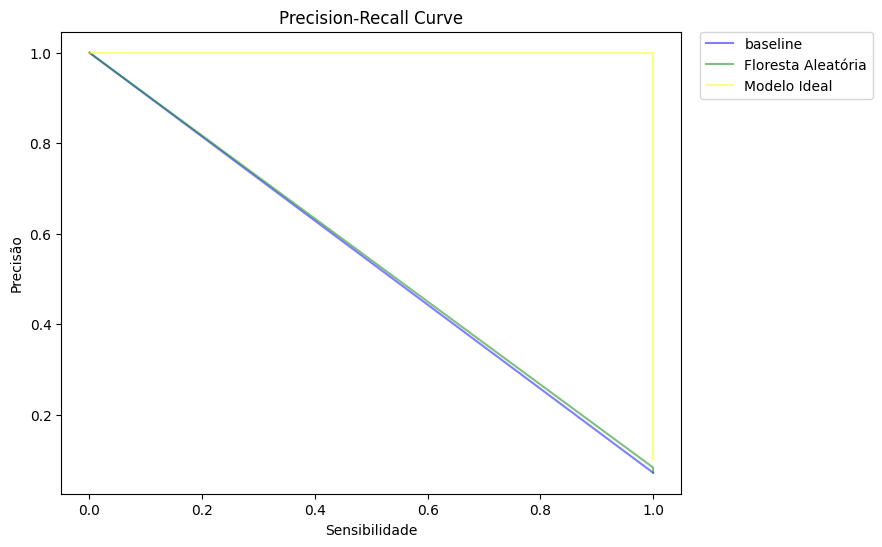

In [14]:
import matplotlib.pyplot as plt

recall_ideal = [0.0 , 1.0 , 1.0]
precision_ideal = [1.0, 1.0, 0.1]

plt.figure(figsize=(8, 6))
plt.plot(recall_baseline, precision_baseline, color='blue',alpha= 0.5, label='baseline')
plt.plot(recall_rf, precision_rf, color='green', alpha= 0.5, label='Floresta Aleatória')
plt.plot(recall_ideal, precision_ideal, color='yellow', alpha= 0.5, label='Modelo Ideal')
plt.xlabel('Sensibilidade')
plt.ylabel('Precisão')
plt.title('Precision-Recall Curve')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.32, 1.015))
plt.show()

<p style="text-align:justify;">Visualmente, aparenta que o modelo de floresta aleatória parece apresentar uma curva um pouca acima das demais, sugerindo uma melhor perfomance. Podemos analisar isso também de forma qualitativa, calculando o área abaixo das curvas (<strong>AUC</strong>). 

##### Calculando a Área Abaixo da Curva

In [15]:
from sklearn.metrics import auc

auc_baseline = auc(recall_baseline, precision_baseline)
auc_rf = auc(recall_rf, precision_rf)

print (f'AUC do baseline = {auc_baseline}')
print (f'AUC da floresta aleatória = {auc_rf}')

AUC do baseline = 0.5358851674641149
AUC da floresta aleatória = 0.5416666666666666


<p style="text-align:justify;">Com esses números fica claro que realmente a floresta aleatória, apresenta uma maior perfomance do que a baseline, mesmo que por muito pouco. Isso nos apresenta o desafio de trabalhar com dados extramamente desbalanceados, o que gera a dificuldade de treinar modelos classificadores que consigam discernir dados classes 1 quando foi treinado praticamente por dados de classe 0 em sua maioria.

#### Testando o modelo gerado especificamente para os dados de alta sobrevividade

<p style="text-align:justify;"> Nesse momento, buscamos analisar a resposta que o modelo daria para pacientes com alta sobrevividade (entre 55 e 60 meses).

In [16]:
X_teste = alta_sobrevida.reindex(ATRIBUTOS, axis=1).values
y_teste = alta_sobrevida.reindex(TARGET_clas, axis=1).values.ravel()

y_verdadeiro = y_teste
y_previsao = modelo_rf.predict(X_teste)

for y_verd, y_test in zip (y_verdadeiro,y_teste):
        print(
        f"Era Curado = {y_verd} e previu Curado = {y_test}. "
    )

Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 
Era Curado = 0 e previu Curado = 0. 


Se percebe, que nesse caso, o modelo previu todos os pacientes certo. Isto já era esperado, visto que o modelo se assemelha ao baseline que sempre prevê o paciente como Não-Curado (Seguindo a moda dos dados no dataset estudado).

## Modelo Regressor: Qual o tempo de sobrevida de um paciente que não foi previsto como curado? 


<p style="text-align:justify;"> Com o <strong>modelo regressor</strong>, pode-se utilizar o modelo baseline, para conseguir tem um ponto de partida de um modelo que não seria minimamente bom, pois o baseline prediz com a média dos dados. Assim como, modelamos nossos dados, pacientes de câncer de pulmão de células não pequenas com até 60 meses de sobrevida, com o modelo KNN e o de floresta aleatória. Ademais, estudamos o melhor grupo de hiperparâmetros e realizamos a seleção de atributos pelo fator de inflação de variância (VIF). 


### Passos para chegar ao melhor modelo regressor

Selecionando somente os falecidos 


In [17]:
df_regre = df.loc[df["Curado"] == 0]
df_regre = df_regre.dropna()

#### Split em treino em teste

In [18]:
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 20404

df_regre = df_regre.reindex(ATRIBUTOS_VIF + TARGET_regre, axis=1)
df_regre = df_regre.dropna()

indices = df_regre.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df_regre.loc[indices_treino]
df_teste = df_regre.loc[indices_teste]

X_treino = df_treino.reindex(ATRIBUTOS_VIF, axis=1).values
y_treino = df_treino.reindex(TARGET_regre, axis=1).values.ravel()

X_teste = df_teste.reindex(ATRIBUTOS_VIF, axis=1).values
y_teste = df_teste.reindex(TARGET_regre, axis=1).values.ravel()

X = df_regre.reindex(ATRIBUTOS_VIF, axis=1).values
y = df_regre.reindex(TARGET_regre, axis=1).values.ravel()

#### Encontrando o melhor grupo de hiperparâmetros salvo

In [19]:
from optuna import load_study

NOME_DO_ESTUDO = "hiperparametros1"

objeto_de_estudo_carregado = load_study(
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
)

melhor_trial = objeto_de_estudo_carregado.best_trial
melhor_trial.params

{'num_arvores': 328,
 'critério': 'poisson',
 'min_exemplos_split': 33,
 'min_exemplos_folha': 10,
 'num_max_atributos': 0.373378161075968}

#### Floresta aleatória com o `scikit-learn`

<p style="text-align:justify;"> Nessa etapa, com os atributos que evitam multicolinearidade selecionados e os melhores hiperparâmentros encontrados pelo optuna, é momento de gerar o melhor modelo encontrado por esse conjunto de algorítmos. Para obter um bom estimador de performance do modelo, irá usar validação cruzada <i>k</i>​-fold.



#### Avaliando a performance com os dados de teste

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

modelo = RandomForestRegressor(n_estimators = 328, criterion = 'poisson',
                                   min_samples_split = 33, min_samples_leaf = 10,
                                   max_features = 0.373378161075968)
modelo.fit(X_treino, y_treino)

y_verdadeiro = y_teste
y_previsao = modelo.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao) ** (1/2)

print(RMSE)

13.163438381653286


#### Encontrando a performance do modelo com a validação cruzada <i>k</i>​-fold.

In [21]:
from sklearn.model_selection import cross_val_score

NUM_FOLDS = 40
SEMENTE_ALEATORIA = 20404
modelo_ad = modelo

metricas = cross_val_score(
    modelo_ad,    #instancia
    X,            #dados de atributos
    y,            #dados de target
    cv=NUM_FOLDS, #número de folds
    scoring="neg_root_mean_squared_error", #quanto maior, melhor pelo scikit
)

print("As métricas foram:", metricas)
print()
print("A média das métricas é de:", np.abs(metricas.mean()))

As métricas foram: [-12.86953877 -16.10537574 -11.14886867 -13.43588143 -13.61319716
 -16.84803015 -13.42226952 -14.5498544  -15.09658292 -15.47288517
 -14.43101615 -17.05057536 -15.12708902 -14.32276909 -14.27048895
 -13.40288346 -15.75232226 -11.91693574 -14.65600016 -12.90380412
 -10.51079385 -13.63450074 -10.80909292 -11.77242151  -9.98173258
  -9.44495194 -10.09554528 -10.07787572  -8.00543426  -8.36402572
  -7.93179692  -8.38431163  -6.97443583  -6.92104053  -9.46499716
  -9.48577167  -8.88665226  -8.02648212  -9.66837319  -8.20590634]

A média das métricas é de: 11.826062760567416


#### Testando o modelo gerado especificamente para os dados de alta sobrevividade

<p style="text-align:justify;"> Nesse momento, o foco é entender a performance do modelo treinado para os pacientes que estão no limiar entre curados ou não, os com mais de 55 meses de sobrevida.

In [22]:
X_teste = alta_sobrevida.reindex(ATRIBUTOS_VIF, axis=1).values
y_teste = alta_sobrevida.reindex(TARGET_regre, axis=1).values.ravel()

y_verdadeiro = y_teste
y_previsao = modelo.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao) ** (1/2)

print(RMSE)

39.29240171316726


<p style="text-align:justify;"> Isso mostra como o modelo tem bastante dificuldade em prever pacientes que apresentam uma alta sobrevida, possivelmente pela quantidade de dados desse grupo que ele teve acesso. O modelo foi gerado a partir de milhares de pacientes, contudo no intervalo dos últimos quatro meses dos 60 de supervisão apresentou apenas 6 pacientes. 

## Conclusão
<p style="text-align:justify;"> Portanto, o trabalho foi bastante proveitoso para entender todas as dificuldades que a modelagem de dados de saúde apresentam. Desde a limitação na quantidade pacientes até as informações relevantes na saúde de um paciente que não possuímos. Para alcançar nossos resultados, verificamos a multicolinearidade com a seleção de atributos pelo fator de inflação de variância (VIF), o melhor grupo de hiperparâmetros pelo optuna e encontramos um valor de RMSE coerente com a performance, pois foi utilizado a validação cruzada </i>k</i>​-fold.
<p>

<p style="text-align:justify;"> Para o modelo classificador, que prediz se um paciente será curado ou não, foi realizado um comparativo entre os modelos de regressão logística, floresta aleatória e baseline. Como resultado, o modelo de floresta aleatória foi selecionado. A análise do gráfico de Precisão-Sensibilidade, juntamente com o cálculo da área abaixo da curva, permitiu determinar que este foi o modelo com o melhor desempenho. Por outro lado, é evidente que trabalhar com dados extremamente desbalanceados impõe limitações ao modelo classificador. Portanto, a inclusão de mais dados, especialmente da classe 1, e de outros atributos relevantes seria altamente benéfica para melhorar o desempenho do modelo.

<p style="text-align:justify;"> Para o modelo regressor, o qual prediz uma sobrevida para pacientes que foram considerados não curados pelo modelo classificador, desenvolvemos o modelo baseline para ser um ponto de partida e verificamos a performance do modelo KNN e da floresta aleatória. Observamos que a diferença do RMSE foi bastante sutil, o que foi coerente com esperado de uma modelagem com dados de saúde. Ademais, o modelo regressor foi desenvolvido a partir do dataset original, apenas selecionando os pacienetes de câncer de pulmão de células não pequenas que teve uma sobrevida até 60 meses, então não há erro associado de outro modelo. Essa decisão foi tomada com o objetivo de diminuir o desvio entre a predição e a sobrevidade de pacientes que o primeiro modelo identificou que não seriam curados, apresentaria sobrevida menor que 60 meses. Assim como, se o modelo fosse predizer uma sobrevida de mais de 60 meses não faria tanto sentido com a realidade, pois qualquer sobrevida acima de 60 meses implica em pacientes curados. 


### Referências

<p style="text-align:justify;">[1] Nguyen, Bastien, Christopher Fong, Anisha Luthra, Shaleigh A. Smith, Renzo G. DiNatale, Subhiksha Nandakumar, Henry Walch, et al. “Genomic Characterization of Metastatic Patterns from Prospective Clinical Sequencing of 25,000 Patients”. Cell 185, nº 3 (3 de fevereiro de 2022): 563-575.e11. https://doi.org/10.1016/j.cell.2022.01.003.
<p style="text-align:justify;">[2] scikit-learn. “6.3. Preprocessing Data”. Acesso em 9 de outubro de 2024. https://scikit-learn/stable/modules/preprocessing.html.
<p style="text-align:justify;">[3] “ATP-203 1.1 - Tratamento de dados”. Acesso em 9 de outubro de 2024. 
<p style="text-align:justify;">[4] “ATP-203 5.1 - Floresta aleatória”. Acesso em 9 de outubro de 2024. 
<p style="text-align:justify;">[5] "ATP-203 9.1 - Classificação binária". Acesso em 10 de novembro de 2024. 